In [1]:
import tensorflow as tf
#tf.reset_default_graph()


sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib.layers import batch_norm
from keras.regularizers import l1
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.layers import batch_normalization

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
class ConvGRUCell(tf.nn.rnn_cell.RNNCell):
  """A GRU cell with convolutions instead of multiplications."""

  def __init__(self, shape, filters, kernel, padding = 'SAME', activation=tf.tanh, normalize=False, data_format='channels_last', reuse=None):
    super(ConvGRUCell, self).__init__(_reuse=reuse)
    self._filters = filters
    self._kernel = kernel
    self._activation = activation
    self._normalize = normalize
    self._padding = padding
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return self._size

  @property
  def output_size(self):
    return self._size

  def call(self, x, h):
    channels = x.shape[self._feature_axis].value

    with tf.variable_scope('gates'):
      inputs = tf.concat([x, h], axis=self._feature_axis)
      n = channels + self._filters
      m = 2 * self._filters if self._filters > 1 else 2
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, self._padding, data_format=self._data_format)
      if self._normalize:
        r, u = tf.split(y, 2, axis=self._feature_axis)
        r = tf.contrib.layers.layer_norm(r)
        u = tf.contrib.layers.layer_norm(u)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.ones_initializer())
        r, u = tf.split(y, 2, axis=self._feature_axis)
      r, u = tf.sigmoid(r), tf.sigmoid(u)

    with tf.variable_scope('candidate'):
      inputs = tf.concat([x, r * h], axis=self._feature_axis)
      n = channels + self._filters
      m = self._filters
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, self._padding, data_format=self._data_format)
      if self._normalize:
        y = tf.contrib.layers.layer_norm(y)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
      h = u * h + (1 - u) * self._activation(y)

    return h, h

import tensorflow.contrib.slim as slim

def norm(x, norm_type, is_train, G=32, esp=1e-5, scope = 'gn'):
    with tf.variable_scope('{}_norm{}'.format(norm_type, scope)):
        if norm_type == 'none':
            output = x
        elif norm_type == 'batch':
            output = tf.contrib.layers.batch_norm(
                x, center=True, scale=True, decay=0.999,
                is_training=is_train, updates_collections=None
            )
        elif norm_type == 'group':
            # normalize
            # tranpose: [bs, h, w, c] to [bs, c, h, w] following the paper
            x = tf.transpose(x, [0, 3, 1, 2])
            N, C, H, W = x.get_shape().as_list()
            G = min(G, C)
            x = tf.reshape(x, [-1, G, C // G, H, W])
            mean, var = tf.nn.moments(x, [2, 3, 4], keep_dims=True)
            x = (x - mean) / tf.sqrt(var + esp)
            # per channel gamma and beta
            gamma = tf.Variable(tf.constant(1.0, shape=[C]), dtype=tf.float32, name='gamma')
            beta = tf.Variable(tf.constant(0.0, shape=[C]), dtype=tf.float32, name='beta')
            gamma = tf.reshape(gamma, [1, C, 1, 1])
            beta = tf.reshape(beta, [1, C, 1, 1])

            output = tf.reshape(x, [-1, C, H, W]) * gamma + beta
            # tranpose: [bs, c, h, w, c] to [bs, h, w, c] following the paper
            output = tf.transpose(output, [0, 2, 3, 1])
        else:
            raise NotImplementedError
    return output

def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, momentum = 0.9, training=training, renorm = True, reuse=None, name = scope)
        #return tf.cond(training,
         #              lambda : batch_normalization(inputs=x, momentum = 0.9, training=True, reuse=None, name = scope),
        #               lambda : batch_normalization(inputs=x, momentum=0.9, training=False, reuse=True, name = scope))

        
#def Batch_Normalization(x, training, groups, scope):
#    print(x)
#    return norm(x = x, norm_type = 'group', is_train = training, G = groups, scope = scope)

In [3]:
#tf.reset_default_graph()
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')



In [4]:
weights = tf.ones([14, 14], tf.float32)
weights = tf.pad(weights, [[1, 1], [1, 1]], 'constant')
weights = tf.reshape(weights, (16*16,)) 
print(weights.shape)

(256,)


In [5]:
reg = keras.regularizers.l2(0.01)
inp = tf.placeholder(tf.float32, shape=(None, 24, 14, 14, 13))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 16, 16))#, 1))

length2 = tf.reshape(length, (-1,))
is_training = is_training = tf.placeholder_with_default(False, (), 'is_training')

def Fully_connected(x, units, layer_name='fully_connected') :
    with tf.name_scope(layer_name) :
        return tf.layers.dense(inputs=x, use_bias=True, units=units)

def Relu(x):
    return tf.nn.relu(x)

def Sigmoid(x):
    return tf.nn.sigmoid(x)

def Global_Average_Pooling(x):
    return global_avg_pool(x, name='Global_avg_pooling')

def Squeeze_excitation_layer(input_x, out_dim, ratio, layer_name):
    with tf.name_scope(layer_name) :
        squeeze = global_avg_pool(input_x)

        excitation = Fully_connected(squeeze, units=out_dim / ratio, layer_name=layer_name+'_fully_connected1')
        excitation = Relu(excitation)
        excitation = Fully_connected(excitation, units=out_dim, layer_name=layer_name+'_fully_connected2')
        excitation = Sigmoid(excitation)

        excitation = tf.reshape(excitation, [-1,1,1,out_dim])

        scale = input_x * excitation

        return scale
    
inp_pad = tf.pad(inp, [[0, 0], [0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
print(inp_pad.shape)

with tf.variable_scope('10'):
    # Downsampling Block 1 (14 x 14)
    cell_10 = ConvGRUCell(shape = [16, 16],
                   filters = 12,
                   kernel = [3,3],
                   padding = 'SAME')

    def convGRU(x, cell, ln):
        output, final = tf.nn.bidirectional_dynamic_rnn(
            cell, cell, x, ln, dtype=tf.float32)
        output = tf.concat(output, -1)
        final = tf.concat(final, -1)
        return [output, final]

# Return the final state and the output states
first_conv = convGRU(inp_pad, cell_10, length2)
print("FIRST GRU {}".format(first_conv[0].shape))

downsampled = TimeDistributed(MaxPool2D(pool_size = (2, 2)))(first_conv[0])
print("DOWNSAMPLE {}".format(downsampled.shape))

# Downsampling block 2 (7 x 7)
with tf.variable_scope('8'):
    cell_7 = ConvGRUCell(shape = [8, 8],
                   filters = 18,
                   kernel = [3,3],
                   padding = 'SAME')
    state_7 = convGRU(downsampled, cell_7, length2)
downsampled_4 = TimeDistributed(MaxPool2D(pool_size = (2, 2)))(state_7[0])
print("SECOND GRU {}".format(state_7[1].shape))

with tf.variable_scope('4'):
    cell_4 = ConvGRUCell(shape = [4, 4],
                   filters = 24,
                   kernel = [3,3],
                   padding = 'SAME')
    state_4 = convGRU(downsampled_4, cell_4, length2)
print("THIRD GRU {}".format(state_4[1].shape))

# 4x4 - 4x4
conv_block_7_u = Conv2D(filters = 30, kernel_size = (3, 3), padding = 'same', activity_regularizer=reg)(state_4[1])
elu_7_u = ELU()(conv_block_7_u)
x = Batch_Normalization(elu_7_u, training=is_training, scope = 'bn1')
#x = batchnorm(elu_7_u, is_training, 'bn1')
squeezed = Squeeze_excitation_layer(input_x = x, out_dim = 30, ratio = 4, layer_name = "squeezed")
print("Down block conv {}".format(elu_7_u.shape))

# 4x4 - 8x8
upsampling_8 = tf.keras.layers.Conv2DTranspose(filters = 30, kernel_size = (3, 3), strides=(2, 2), padding='same')(squeezed)
concat_8 = Concatenate(axis = -1)([upsampling_8, state_7[1]])
padded_8 = ReflectionPadding2D((1, 1))(concat_8)
conv_8 = Conv2D(filters = 30,
            kernel_size = (3, 3), 
            padding = 'valid',
            activity_regularizer=reg,
            )(padded_8)
elu_8 = ELU()(conv_8)
#bn_8 = batchnorm(elu_8, is_training, 'bn2')
bn_8 = Batch_Normalization(elu_8, training=is_training, scope = 'bn8')
squeeze_8 = Squeeze_excitation_layer(input_x = bn_8, out_dim = 30, ratio = 4, layer_name = "squeezed_8")
print("Upblock 8 {}".format(squeeze_8.shape))

# 8x8 - 16 x 16
upsampling_16 = tf.keras.layers.Conv2DTranspose(filters = 18, kernel_size = (3, 3), strides=(2, 2), padding='same')(squeeze_8)
concat_16 = Concatenate(axis = -1)([upsampling_16, first_conv[1]])
padded_16 = ReflectionPadding2D((1, 1))(concat_16)
conv_16 = Conv2D(filters = 18,
            kernel_size = (3, 3), 
            padding = 'valid',
            activity_regularizer=reg,
            )(padded_16)
elu_16 = ELU()(conv_16)
#bn_16 = batchnorm(elu_16, is_training, 'bn3')
bn_16 = Batch_Normalization(elu_16, training=is_training, scope = 'bn16')
squeezed_16 = Squeeze_excitation_layer(input_x = bn_16, out_dim = 18, ratio = 4, layer_name = "squeezed_16")
print("Up block 16 {}".format(squeezed_16.shape))

padded = ReflectionPadding2D((1, 1))(squeezed_16)
fm = Conv2D(filters = 12,
            kernel_size = (3, 3), 
            padding = 'valid',
            activity_regularizer=reg,
            )(padded)
elu = ELU()(fm)
bn_final = Batch_Normalization(elu, training=is_training, scope = 'bnfinal')
squeezed_16 = Squeeze_excitation_layer(input_x = bn_final, out_dim = 12, ratio = 4, layer_name = "squeezed_final")
print("Up block conv 3 {}".format(squeezed_16.shape))
# Output layer
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid'
            )(squeezed_16)
print(fm.shape)

(?, 24, 16, 16, 13)
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
FIRST GRU (?, 24, 16, 16, 24)
DOWNSAMPLE (?, 24, 8, 8, 24)
SECOND GRU (?, 8, 8, 36)
THIRD GRU (?, 4, 4, 48)
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Down block conv (?, 4, 4, 30)
Upblock 8 (?, 8, 8, 30)
Up block 16 (?, 16, 16, 18)
Up block conv 3 (?, 16, 16, 12)
(?, 16, 16, 1)


In [6]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

5400
24
2700
12
13608
36
6804
18
25920
48
12960
24
12960
30
30
30
210
7
210
30
8100
30
17820
30
30
30
210
7
210
30
4860
18
6804
18
18
18
72
4
72
18
1944
12
12
12
36
3
36
12
12
1
121540


In [7]:

df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")

df = df.drop('IMAGERY_TITLE', axis = 1)
df1 = df1.drop('IMAGERY_TITLE', axis = 1)
df = pd.concat([df, df1], ignore_index = True)
df = df.dropna(axis = 0)


N_SAMPLES = int(df.shape[0]/196)
print(N_SAMPLES)

plot_ids = sorted(df['PLOT_ID'].unique())

def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]

def remove_blank_steps(array):
    to_update = {}
    sets = []
    for k in range(6):
        for i in range(array.shape[0]):
            for k in range(array.shape[-1]):
                mean = (np.mean(array[i, :, :, k]))
                if mean == 0:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
                if mean == 1:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
    for i in range(array.shape[0]):
        for k in range(array.shape[-1]):
            mean = (np.mean(array[i, :, :, k]))
            if mean == 0:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
            if mean == 1:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
    return array

import os
image_size = 14

def ndvi(x):
    # (B8 - B4)/(B8 + B4)
    ndvis = [(im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2]) for im in x]
    min_ndvi = min([np.min(x) for x in ndvis])
    max_ndvi = max([np.max(x) for x in ndvis])
    if min_ndvi < -1 or max_ndvi > 1:
        print("ERROR")
    ndvis = [((x + 1) / 2) for x in ndvis]
    min_ndvi = min([np.min(x) for x in ndvis])
    max_ndvi = max([np.max(x) for x in ndvis])
    print(min_ndvi, max_ndvi)
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 10] = ndvis[i]
    return x

def evi(x):
    # 2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    evis = [2.5 * ((im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + 6 * im[:,:, 2] - 7.5 * im[:, :, 0] + 1)) for im in x]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 11] = evis[i]
    return x
    
def savi(x):
    # (1.5)(08 - 04)/ (08 + 04 + 0.5)
    savis = [(1.5 * im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2] + 0.5) for im in x]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 12] = savis[i]
    return x

# Initiate empty lists to store the X and Y data in
data_x = []
data_y = []
binary_y = []
data_location_x = []
data_location_y = []
lengths = []

# Iterate over each plot
pad = True
flip = True
for i in plot_ids:
    # Load the sentinel imagery
    x = np.load("../data/ids/" + str(i) + ".npy")
    # Shape check
    if x.shape[1] == image_size:
        x = ndvi(x)                # calc NDVI
        x = evi(x)
        x = savi(x)
        x = remove_blank_steps(x)
        y = reconstruct_images(i)
        if sum([sum(x) for x in y]) >= 1:
            binary_y.append(1)
        else:
            binary_y.append(0)
        lengths.append(x.shape[0])
        #x = np.median(x, axis = 0) # and calculate the median over the time steps
        if pad:
            if x.shape[0] < 24:
                print(x.shape[0])
                padding = np.zeros((24 - x.shape[0], image_size, image_size, 13))
                x = np.concatenate((x, padding), axis = 0)
        data_x.append(x)
        data_y.append(y)
        if flip:
                # FLIP HORIZONTAL
            x1 = np.flip(x, 1)
            data_x.append(x1)
            data_y.append(np.flip(y, 0))
            lengths.append(x.shape[0])
    
                # FLIP BOTH
            x2 = np.flip(x, 2)
            x2 = np.flip(x2, 1)
            data_x.append(x2)
            data_y.append(np.flip(y, [0, 1]))
            lengths.append(x.shape[0])
                # FLIP VERTICAL
            x3 = np.flip(x, 2)
            data_x.append(x3)
            data_y.append(np.flip(y, 1))
            lengths.append(x.shape[0])

data_x = np.stack(data_x)
data_y = np.stack(data_y)
data_y = np.reshape(data_y, (N_SAMPLES*4, 14, 14, 1))
binary_y = np.stack(binary_y)
lengths = np.stack(lengths)
lengths = np.reshape(lengths, (lengths.shape[0], 1))

336
0.4461283 0.822736
0.5209696 0.9992913
0.3871069 0.7687279
0.33417815 0.80240464
0.43925235 0.99593914
0.4849003 0.77837324
0.018518478 0.9987654
0.13065934 0.9992756
0.45570484 0.70296013
0.47435188 0.97602654
0.5119076 0.89559996
0.46538663 0.8341109
0.20434779 0.9995545
0.13010052 0.5987441
0.37679574 0.7240851
0.4334727 0.67701864
0.48435426 0.9996896
0.44893616 0.99915755
0.43766215 0.8044272
0.43555382 0.8501582
0.39542374 0.80423415
0.5221932 0.93538916
0.46930695 0.8748112
0.45717004 0.7600787
0.49347302 0.999159
0.39788824 0.9997599
0.48372936 0.96422374
0.1746633 0.69592154
0.47258085 0.91107
0.46889305 0.7382716
0.19358599 0.8195106
0.48991695 0.85940486
0.12084326 0.92077863
0.43802115 0.77538574
0.49526104 0.86184084
0.0 0.7867664
0.4694168 0.9035882
0.3597304 0.99970436
0.5541066 0.86154914
0.42335027 0.8445461
0.41079596 0.92014974
0.5174932 0.9014919
0.46615216 0.9996344
0.49331236 0.99968636
0.46103796 0.99967337
0.15917441 0.7417355
0.37985706 0.95710707
0.4656337

In [8]:
def bin_foc(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(0.5 * K.pow(1. - pt_1, 2) * K.log(pt_1)) \
               -K.sum((1 - 0.5) * K.pow(pt_0, 2) * K.log(1. - pt_0))  
    
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = prediction_tensor
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def foc_lovasz(y_true, y_pred):
    #jaccard_loss = jaccard_distance(y_true, y_pred)
    lovasz = lovasz_hinge(y_pred, y_true)
    #pred_reshape = tf.reshape(y_pred, (-1, 14, 14))
    #true_reshape = tf.reshape(y_true, (-1, 14, 14))
    focal_loss = bin_foc(y_true, y_pred)
    summed = lovasz + np.log(focal_loss)
    return summed

In [9]:
def thirty_meter(true, pred):
    indices_x = [x for x in range(0, 13, 1)]
    indices_y = [x for x in range(0, 13, 1)]
    perms = [(y, x) for x, y in itertools.product(indices_y, indices_x)]
    
    #perms = ([list(zip(indices_x, p)) for p in itertools.permutations(indices_y)])
    #perms = [item for sublist in perms for item in sublist]
    #perms = list(set(perms))
    indexes = [([a, a + 1], [b, b + 1]) for a,b in perms]
    subs_true = []
    subs_pred = []
    for i in indexes:
        true_i = true[i[0][0]:i[0][1], i[1][0]:i[1][1]]
        pred_i = pred[i[0][0]:i[0][1], i[1][0]:i[1][1]]
        subs_true.append(true_i)
        subs_pred.append(pred_i)
    pred = [np.sum(x) for x in subs_pred]
    true = [np.sum(x) for x in subs_true]
    true_positives = []
    false_positives = []
    false_negatives = []
    for p, t in zip(pred, true):
        if p > t:
            tp = p - (p - t)
            fp = p - tp
            fn = 0
        if t >= p:
            tp = t
            fp = 0
            fn = t - p
        true_positives.append(tp)
        false_positives.append(fp)
        false_negatives.append(fn)
    prec = [x / (x + y) for x,y in zip(true_positives, false_positives) if (x+y) > 0]
    prec = [x for x in prec if not np.isnan(x)]
    rec = [x / (x + y) for x,y in zip(true_positives, false_negatives) if (x+y) > 0]
    rec = [x for x in rec if not np.isnan(x)]
    
    #recall = [min(x / y, 1) for x, y in zip(pred, true) if y > 0]
    #precision = [(y - x) / x for x, y in zip(pred, true)]
    #print(precision)
    return rec, prec

In [10]:


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None, order='BHWC'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, H, W, C] or [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
      order: use BHWC or BCHW
    """
    if per_image:
        def treat_image(prob_lab):
            prob, lab = prob_lab
            prob, lab = tf.expand_dims(prob, 0), tf.expand_dims(lab, 0)
            prob, lab = flatten_probas(prob, lab, ignore, order)
            return lovasz_softmax_flat(prob, lab, classes=classes)
        losses = tf.map_fn(treat_image, (probas, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore, order), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    C = probas.shape[1]
    losses = []
    present = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = tf.cast(tf.equal(labels, c), probas.dtype)  # foreground for class c
        if classes == 'present':
            present.append(tf.reduce_sum(fg) > 0)
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = tf.abs(fg - class_pred)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort_{}".format(c))
        fg_sorted = tf.gather(fg, perm)
        grad = lovasz_grad(fg_sorted)
        losses.append(
            tf.tensordot(errors_sorted, tf.stop_gradient(grad), 1, name="loss_class_{}".format(c))
                      )
    if len(class_to_sum) == 1:  # short-circuit mean when only one class
        return losses[0]
    losses_tensor = tf.stack(losses)
    if classes == 'present':
        present = tf.stack(present)
        losses_tensor = tf.boolean_mask(losses_tensor, present)
    loss = tf.reduce_mean(losses_tensor)
    return loss


def flatten_probas(probas, labels, ignore=None, order='BHWC'):
    """
    Flattens predictions in the batch
    """
    if len(probas.shape) == 3:
        probas, order = tf.expand_dims(probas, 3), 'BHWC'
    if order == 'BCHW':
        probas = tf.transpose(probas, (0, 2, 3, 1), name="BCHW_to_BHWC")
        order = 'BHWC'
    if order != 'BHWC':
        raise NotImplementedError('Order {} unknown'.format(order))
    C = probas.shape[3]
    probas = tf.reshape(probas, (-1, C))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return probas, labels
    valid = tf.not_equal(labels, ignore)
    vprobas = tf.boolean_mask(probas, valid, name='valid_probas')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vprobas, vlabels

In [11]:
data_y = np.pad(data_y, [[0, 0], [1, 1], [1, 1], [0, 0]], 'constant')

In [ ]:
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops

def weighted_cross_entropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    y_pred = tf.log(y_pred / (1 - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=2.)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def smooth_jaccard(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def bce_jaccard(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 16, 16, 1))
    return binary_crossentropy(y_true, y_pred) + (0.5 * smooth_jaccard(y_true, y_pred))

def bce_lovasz(y_true, y_pred):
    return binary_crossentropy(tf.reshape(y_true, (-1, 14, 14, 1)), y_pred) + lovasz_softmax(y_pred, y_true, classes=[1], per_image=False)

def foc_jaccard(y_true, y_pred):
    print(y_true.shape)
    y_true_r = tf.reshape(y_true, (-1, 16, 16, 1))
    y_pred_r = tf.reshape(y_pred, (-1, 16, 16))
    y_true_f = tf.reshape(y_true, (-1, 16*16, 1))
    y_pred_f = tf.reshape(y_pred, (-1, 16*16, 1))
    jac = smooth_jaccard(y_true_r, y_pred)
    foc = focal_loss(y_pred_f, y_true_f, alpha=0.5, gamma=1.5, weights = weights)
    return foc

optimizer = AdaBoundOptimizer(learning_rate=1e-6, final_lr=5e-5, beta1=0.9, beta2=0.999, amsbound=True)
loss2 = bce_jaccard(labels, fm)
#
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss2)

init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 2)

# dev --> 225

# Run training loop
for i in range(100):
    randomize = np.arange(1088)
    np.random.shuffle(randomize)
    test_randomize = np.arange(1088, 1344)
    np.random.shuffle(test_randomize)

    losses = []
    val_loss = []

    for k in range(68*4):
        batch_ids = randomize[k*4:(k+1)*4]
        op, tr = sess.run([train_op, loss2], feed_dict={inp: data_x[batch_ids, :, :, :],
                                                        length: lengths[batch_ids],
                                                        labels: data_y[batch_ids, :, :].reshape(4, 16, 16),
                                                        is_training: True
                                                        })
        losses.append(tr)
    for j in range(32):
        batch_ids = test_randomize[j*8:(j+1)*8]
        vl, y = sess.run([loss2, fm], feed_dict={inp: data_x[batch_ids, :, :, :],
                                                 length: lengths[batch_ids],
                                                 labels: data_y[batch_ids, :, :].reshape(8, 16, 16),
                                                 is_training: False,
                                                })
        val_loss.append(vl)
        
    recalls = []
    precisions = []
    for m in range(1088, 1344):
        y = sess.run([fm], feed_dict={inp: data_x[m].reshape(1, 24, 14, 14, 13),
                                  length: lengths[m].reshape(1, 1),
                                  is_training: False,
                                  })[0]
        true = data_y[m].reshape((16, 16))
        pred = y.reshape((16, 16))
        pred = pred[1:15, 1:15]
        true = true[1:15, 1:15]
        #pred = np.sigmoid(pred)
        pred[np.where(pred > 0.45)] = 1
        pred[np.where(pred < 0.45)] = 0
        rec, prec = thirty_meter(true, pred)
        recalls.append(rec)
        precisions.append(prec)
    precisions = [item for sublist in precisions for item in sublist]
    recalls = [item for sublist in recalls for item in sublist]
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    save_path = saver.save(sess, "../models/dev/model")
    if np.mean(val_loss) < 0.27:
        save_path = saver.save(sess, "../models/dev_best/model")
    print("Epoch {}: Loss {} Val: {} P {} R {} F1 {}".format(i + 1,
                                                             np.mean(losses), np.mean(val_loss),
                                                             precision, recall, f1_score))

Epoch 1: Loss 0.8139517307281494 Val: 0.600934624671936 P 0.5896696137738483 R 0.6586174242424242 F1 0.622239389419494
Epoch 2: Loss 0.4770493805408478 Val: 0.38646334409713745 P 0.9023070350327542 R 0.5984848484848485 F1 0.7196428699796564
Epoch 3: Loss 0.3798139691352844 Val: 0.34605973958969116 P 0.9209302325581395 R 0.5965119949494949 F1 0.7240419704608414
Epoch 4: Loss 0.35712310671806335 Val: 0.32115769386291504 P 0.8432259781740751 R 0.6307607323232324 F1 0.7216806389354826
Epoch 5: Loss 0.34868431091308594 Val: 0.32279810309410095 P 0.8664022972788186 R 0.6295770202020202 F1 0.7292440079125228
Epoch 6: Loss 0.3402796983718872 Val: 0.3050217032432556 P 0.854138581827986 R 0.6395991161616161 F1 0.7314621338833197
Epoch 7: Loss 0.3343500792980194 Val: 0.31565213203430176 P 0.9523523222606343 R 0.5946969696969697 F1 0.7321822815556313
Epoch 8: Loss 0.32815682888031006 Val: 0.3000420928001404 P 0.898086463501063 R 0.6313920454545454 F1 0.7414875669906298
Epoch 9: Loss 0.327566415071

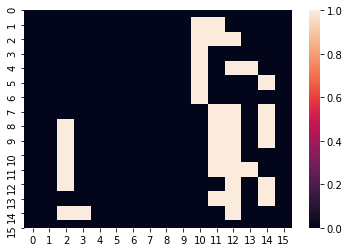

In [54]:
idx = int((len(data_x))*0.8) + 20# 105, 25, 215, 90, 140
y = sess.run([fm], feed_dict={inp: data_x[idx].reshape(1, 24, 14, 14, 13),
                              length: lengths[idx].reshape(1, 1),
                              is_training: False,
                              })

sns.heatmap(data_y[idx][:, :, :].reshape(16, 16))

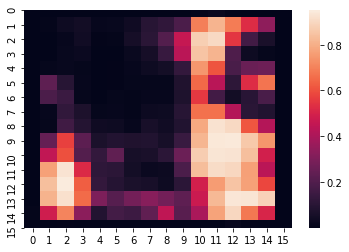

In [55]:
pred = y[0][:, :, :].reshape(16, 16)
#pred[np.where(pred > 0.3)] = 1
sns.heatmap(pred)

In [39]:
recalls = []
precisions = []
for i in range(1088, 1344):
    y = sess.run([fm], feed_dict={inp: data_x[i].reshape(1, 24, 14, 14, 13),
                              length: lengths[i].reshape(1, 1),
                              is_training: False,
                              })[0]
    true = data_y[i].reshape((16, 16))
    pred = y.reshape((16, 16))
    pred = pred[1:15, 1:15]
    true = true[1:15, 1:15]
    pred[np.where(pred > 0.48)] = 1
    pred[np.where(pred < 0.48)] = 0
    rec, prec = thirty_meter(true, pred)
    #rec, prec = half_hectare_accuracy(true, pred)
    recalls.append(rec)
    precisions.append(prec)

In [40]:
recalls = [item for sublist in recalls for item in sublist]
np.mean(recalls)

0.7482638888888888

In [41]:
precisions = [item for sublist in precisions for item in sublist]
np.mean(precisions)

0.7361449982572325

In [12]:
"""AdaBound for TensorFlow."""

from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import resource_variable_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.training import optimizer
from tensorflow.python.ops.clip_ops import clip_by_value

"""Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

class AdaBoundOptimizer(optimizer.Optimizer):
    def __init__(self, learning_rate=0.001, final_lr=0.1, beta1=0.9, beta2=0.999,
                 gamma=1e-3, epsilon=1e-8, amsbound=False,
                 use_locking=False, name="AdaBound"):
        super(AdaBoundOptimizer, self).__init__(use_locking, name)
        self._lr = learning_rate
        self._final_lr = final_lr
        self._beta1 = beta1
        self._beta2 = beta2
        self._epsilon = epsilon

        self._gamma = gamma
        self._amsbound = amsbound

        self._lr_t = None
        self._beta1_t = None
        self._beta2_t = None
        self._epsilon_t = None

    def _create_slots(self, var_list):
        first_var = min(var_list, key=lambda x: x.name)

        graph = None if context.executing_eagerly() else ops.get_default_graph()
        create_new = self._get_non_slot_variable("beta1_power", graph) is None
        if not create_new and context.in_graph_mode():
            create_new = (self._get_non_slot_variable("beta1_power", graph).graph is not first_var.graph)

        if create_new:
            self._create_non_slot_variable(initial_value=self._beta1,
                                           name="beta1_power",
                                           colocate_with=first_var)
            self._create_non_slot_variable(initial_value=self._beta2,
                                           name="beta2_power",
                                           colocate_with=first_var)
            self._create_non_slot_variable(initial_value=self._gamma,
                                           name="gamma_multi",
                                           colocate_with=first_var)
        # Create slots for the first and second moments.
        for v in var_list :
            self._zeros_slot(v, "m", self._name)
            self._zeros_slot(v, "v", self._name)
            self._zeros_slot(v, "vhat", self._name)


    def _prepare(self):
        self._lr_t = ops.convert_to_tensor(self._lr)
        self._base_lr_t = ops.convert_to_tensor(self._lr)
        self._beta1_t = ops.convert_to_tensor(self._beta1)
        self._beta2_t = ops.convert_to_tensor(self._beta2)
        self._epsilon_t = ops.convert_to_tensor(self._epsilon)
        self._gamma_t = ops.convert_to_tensor(self._gamma)

    def _apply_dense(self, grad, var):
        graph = None if context.executing_eagerly() else ops.get_default_graph()
        beta1_power = math_ops.cast(self._get_non_slot_variable("beta1_power", graph=graph), var.dtype.base_dtype)
        beta2_power = math_ops.cast(self._get_non_slot_variable("beta2_power", graph=graph), var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
        base_lr_t = math_ops.cast(self._base_lr_t, var.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)
        gamma_multi = math_ops.cast(self._get_non_slot_variable("gamma_multi", graph=graph), var.dtype.base_dtype)

        step_size = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))
        final_lr = self._final_lr * lr_t / base_lr_t
        lower_bound = final_lr * (1. - 1. / (gamma_multi + 1.))
        upper_bound = final_lr * (1. + 1. / (gamma_multi))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, beta1_t * m + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, beta2_t * v + v_scaled_g_values, use_locking=self._use_locking)

        # amsgrad
        vhat = self.get_slot(var, "vhat")
        if self._amsbound :
            vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
            v_sqrt = math_ops.sqrt(vhat_t)
        else :
            vhat_t = state_ops.assign(vhat, vhat)
            v_sqrt = math_ops.sqrt(v_t)


        # Compute the bounds
        step_size_bound = step_size / (v_sqrt + epsilon_t)
        bounded_lr = m_t * clip_by_value(step_size_bound, lower_bound, upper_bound)

        var_update = state_ops.assign_sub(var, bounded_lr, use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _resource_apply_dense(self, grad, var):
        graph = None if context.executing_eagerly() else ops.get_default_graph()
        beta1_power = math_ops.cast(self._get_non_slot_variable("beta1_power", graph=graph), grad.dtype.base_dtype)
        beta2_power = math_ops.cast(self._get_non_slot_variable("beta2_power", graph=graph), grad.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, grad.dtype.base_dtype)
        base_lr_t = math_ops.cast(self._base_lr_t, var.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, grad.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, grad.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, grad.dtype.base_dtype)
        gamma_multi = math_ops.cast(self._get_non_slot_variable("gamma_multi", graph=graph), var.dtype.base_dtype)

        step_size = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))
        final_lr = self._final_lr * lr_t / base_lr_t
        lower_bound = final_lr * (1. - 1. / (gamma_multi + 1.))
        upper_bound = final_lr * (1. + 1. / (gamma_multi))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, beta1_t * m + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, beta2_t * v + v_scaled_g_values, use_locking=self._use_locking)

        # amsgrad
        vhat = self.get_slot(var, "vhat")
        if self._amsbound:
            vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
            v_sqrt = math_ops.sqrt(vhat_t)
        else:
            vhat_t = state_ops.assign(vhat, vhat)
            v_sqrt = math_ops.sqrt(v_t)

        # Compute the bounds
        step_size_bound = step_size / (v_sqrt + epsilon_t)
        bounded_lr = m_t * clip_by_value(step_size_bound, lower_bound, upper_bound)

        var_update = state_ops.assign_sub(var, bounded_lr, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _apply_sparse_shared(self, grad, var, indices, scatter_add):
        graph = None if context.executing_eagerly() else ops.get_default_graph()
        beta1_power = math_ops.cast(self._get_non_slot_variable("beta1_power", graph=graph), var.dtype.base_dtype)
        beta2_power = math_ops.cast(self._get_non_slot_variable("beta2_power", graph=graph), var.dtype.base_dtype)
        lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
        base_lr_t = math_ops.cast(self._base_lr_t, var.dtype.base_dtype)
        beta1_t = math_ops.cast(self._beta1_t, var.dtype.base_dtype)
        beta2_t = math_ops.cast(self._beta2_t, var.dtype.base_dtype)
        epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)
        gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)

        step_size = (lr_t * math_ops.sqrt(1 - beta2_power) / (1 - beta1_power))
        final_lr = self._final_lr * lr_t / base_lr_t
        lower_bound = final_lr * (1. - 1. / (gamma_t + 1.))
        upper_bound = final_lr * (1. + 1. / (gamma_t))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, "m")
        m_scaled_g_values = grad * (1 - beta1_t)
        m_t = state_ops.assign(m, m * beta1_t, use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, "v")
        v_scaled_g_values = (grad * grad) * (1 - beta2_t)
        v_t = state_ops.assign(v, v * beta2_t, use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = scatter_add(v, indices, v_scaled_g_values)

        # amsgrad
        vhat = self.get_slot(var, "vhat")
        if self._amsbound:
            vhat_t = state_ops.assign(vhat, math_ops.maximum(v_t, vhat))
            v_sqrt = math_ops.sqrt(vhat_t)
        else:
            vhat_t = state_ops.assign(vhat, vhat)
            v_sqrt = math_ops.sqrt(v_t)

        # Compute the bounds
        step_size_bound = step_size / (v_sqrt + epsilon_t)
        bounded_lr = m_t * clip_by_value(step_size_bound, lower_bound, upper_bound)

        var_update = state_ops.assign_sub(var, bounded_lr, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t, vhat_t])

    def _apply_sparse(self, grad, var):
        return self._apply_sparse_shared(
            grad.values, var, grad.indices,
            lambda x, i, v: state_ops.scatter_add(  # pylint: disable=g-long-lambda
                x, i, v, use_locking=self._use_locking))

    def _resource_scatter_add(self, x, i, v):
        with ops.control_dependencies(
                [resource_variable_ops.resource_scatter_add(x, i, v)]):
            return x.value()

    def _resource_apply_sparse(self, grad, var, indices):
        return self._apply_sparse_shared(
            grad, var, indices, self._resource_scatter_add)

    def _finish(self, update_ops, name_scope):
        # Update the power accumulators.
        with ops.control_dependencies(update_ops):
            graph = None if context.executing_eagerly() else ops.get_default_graph()
            beta1_power = self._get_non_slot_variable("beta1_power", graph=graph)
            beta2_power = self._get_non_slot_variable("beta2_power", graph=graph)
            gamma_multi = self._get_non_slot_variable("gamma_multi", graph=graph)
            with ops.colocate_with(beta1_power):
                update_beta1 = beta1_power.assign(
                    beta1_power * self._beta1_t,
                    use_locking=self._use_locking)
                update_beta2 = beta2_power.assign(
                    beta2_power * self._beta2_t,
                    use_locking=self._use_locking)
                update_gamma = gamma_multi.assign(
                    gamma_multi + self._gamma_t,
                    use_locking=self._use_locking)
        return control_flow_ops.group(*update_ops + [update_beta1, update_beta2, update_gamma],
                                      name=name_scope)